In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import histomicstk as htk

from histomicstk.segmentation.label import trace_object_boundaries
from histomicstk.utils import merge_colinear

from skimage.data import astronaut
from skimage.measure import regionprops
from skimage.measure import regionprops_table
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

import SimpleITK as sitk

# Defeat ITK lazy loading so that loading does not affect timings of SLIC algorithm.
import itkConfig
itkConfig.LazyLoading=False
import itk

from fast_slic import Slic

import time

In [2]:
# We use itk2nestedlist to convert an ITK vertex list to an ordinary Python list of lists,
# but it can be used in similar situations as well.
def itk2nestedlist(inp):
    if hasattr(inp, "Size") and hasattr(inp, "GetElement"):
        response = []
        for i in range(inp.Size()):
            response.append(itk2nestedlist(inp.GetElement(i)))
        return response
    else:
        return inp


# trace_object_boundaries2 replaces and is much faster than
# histomicstk.segmentation.label.trace_object_boundaries.
# However, trace_object_boundaries2 currently ignores conn, x_start, y_start, and max_length.
def trace_object_boundaries2(im_label,
                             conn=4, trace_all=False,
                             x_start=None, y_start=None,
                             max_length=None,
                             simplify_colinear_spurs=True,
                             eps_colinear_area=0.01):
    """Performs exterior boundary tracing of one or more objects in a label
    mask. If a starting point is not provided then a raster scan will be performed
    to identify the starting pixel.

    Parameters
    ----------
    im_label : array_like
        A binary mask image.
    conn : int
        Neighborhood connectivity to evaluate. Valid values are 4 or 8.
        Default value = 4.
    trace_all : bool
        Specify True if you want to trace boundaries of all objects.
        Default = False
    x_start : int
        Starting horizontal coordinate to begin tracing. Default value = None.
    y_start : int
        Starting vertical coordinate to begin tracing. Default value = None.
    max_length : int
        Maximum boundary length to trace before terminating. Default value =
        None.
    simplify_colinear_spurs : bool
        If True colinear streaks/spurs in the object boundary will be
        simplified/removed. Note that if the object boundary is entirely
        colinear then the object itself will be removed. Default = True
    eps_colinear_area : int
        Minimum area of triangle formed by three consecutive points on the
        contour for them to be considered ContourExtractor2DImageFilteras non-colinear. Default value =
        0.01.

    Notes
    -----
    The Improved Simple Boundary Follower (ISBF) from the reference below is
    used for 4-connected tracing. This algorithm provides accurate tracing with
    competitive execution times. 8-connected tracing is implemented using the
    Moore tracing algorithm.

    Returns
    -------
    X : array_like
        A set of 1D array of horizontal coordinates of contour seed pixels for
        tracing.
    Y : array_like
        A set of 1D array of the vertical coordinates of seed pixels for
        tracing.

    References
    ----------
    .. [#] J. Seo et al "Fast Contour-Tracing Algorithm Based on a Pixel-
       Following Method for Image Sensors" in Sensors,vol.16,no.353,
       doi:10.3390/s16030353, 2016.

    """

    if max_length is None:
        max_length = float('inf')

    X = []
    Y = []

    if trace_all:

        rprops = regionprops(im_label)
        numLabels = len(rprops)

        x_start = -1
        y_start = -1

        for i in range(numLabels):

            # get bounds of label mask
            min_row, min_col, max_row, max_col = rprops[i].bbox

            mrows = max_row - min_row + 2
            mcols = max_col - min_col + 2

            # grab label mask
            mask = np.zeros((mrows, mcols))
            mask[1:mrows-1, 1:mcols-1] = (
                im_label[
                    min_row:max_row, min_col:max_col
                ] == rprops[i].label
            ).astype(np.bool)

            polylineparametricpath = itk.contour_extractor2_d_image_filter(itk.GetImageFromArray((2*mask).astype(np.uint8)), contour_value=1)
            if isinstance(polylineparametricpath, tuple):
                polylineparametricpath = polylineparametricpath[0]
            polylineparametricpath = polylineparametricpath.GetVertexList()
            polylineparametricpath = itk2nestedlist(polylineparametricpath)
            by, bx = np.transpose(np.array(polylineparametricpath))

            if len(bx) > 0:
                bx = bx + (min_row - 1)
                by = by + (min_col - 1)
                X.append(bx)
                Y.append(by)

    else:

        rprops = regionprops(im_label.astype(int))
        numLabels = len(rprops)

        if numLabels > 1:
            raise ValueError("Number of labels should be 1 !!")

        if ((x_start is None) != (y_start is None)):
            raise ValueError("x_start or y_start is not defined !!")

        if x_start is None and y_start is None:
            x_start = -1
            y_start = -1

        polylineparametricpath = itk.contour_extractor2_d_image_filter(itk.GetImageFromArray((2*label).astype(np.uint8)), contour_value=1)
        if type(polylineparametricpath) == tuple:
            polylineparametricpath = polylineparametricpath[0]
        polylineparametricpath = itk2nestedlist(polylineparametricpath.GetVertexList())
        by, bx = np.transpose(np.array(polylineparametricpath))
            
        if len(bx) > 0:
            X.append(bx)
            Y.append(by)

    return X, Y


# plotit() computes superpixel boundaries using the supplied trace_object_boundaries_function and then
# displays the image, the superpixel centroids, and the superpixel boundaries.
def plotit(countFigure, img, label, trace_object_boundaries_function):
    start = time.time()
    Y, X = trace_object_boundaries_function(label, conn=4, trace_all=True,
                                            simplify_colinear_spurs=True,
                                            eps_colinear_area=0.01)
    X, Y = zip(*[merge_colinear(x,y) for x,y in zip(X,Y)])
    print('Tracing time elapsed: {}'.format(time.time()-start))

    #get superpixel centroids
    centroids = regionprops_table(label, properties=['centroid'])
    cY = centroids['centroid-0']
    cX = centroids['centroid-1']
    
    fig, ax = plt.subplots(num=countFigure)
    ax.imshow(img)
    fig.gca().set_axis_off()
    fig.tight_layout()
    ax.scatter(cX, cY)
    for x,y in zip(X, Y):
        ax.plot(x, y)


In [3]:
img = img_as_float(astronaut()[::2, ::2])
# Tile multiple copies of the image to give this test more to work with.
# img = np.tile(img, (1,2,1))
img = np.tile(img, (8,8,1))
# img = np.tile(img, (16,16,1))

# Time the SLIC calculation for each approach.
# We do not time the conversion between data formats because the production level code will
# use the optimal format throughout rather than switching back and forth.

#skimage
start = time.time()
label1 = slic(img, n_segments=int(img.shape[0]*img.shape[1]/(64.0*64.0)), compactness=1, sigma=1, start_label=1)
print('skimage SLIC time elapsed: %s ' % format(time.time()-start))

#Simple ITK
imgSITK = sitk.GetImageFromArray(img, isVector=True)
start = time.time()
labelSITK = sitk.SLIC(imgSITK, spatialProximityWeight=10.0/256.0, superGridSize=(64,64))
print('SITK SLIC time elapsed: %s ' % format(time.time()-start))
label2 = sitk.GetArrayFromImage(labelSITK)

#ITK
imgITK = itk.image_from_array(img.astype(np.float32), is_vector=True)
start = time.time()
labelITK = itk.slic_image_filter(imgITK, SpatialProximityWeight=10.0/256.0, SuperGridSize=(64,64)
#                                , ttype=(itk.Image[itk.Vector[itk.F,3],2], itk.Image[itk.UL,2])
                                )
print('ITK SLIC time elapsed: %s ' % format(time.time()-start))
label3 = itk.array_from_image(labelITK)

#fast_slic
algFastSLIC = Slic(num_components=int(img.shape[0]*img.shape[1]/(64.0*64.0)), compactness=1)
imgFastSLIC = (img*256).astype(np.uint8)
start = time.time()
label4 = algFastSLIC.iterate(imgFastSLIC)
print('fast_slic time elapsed: %s ' % format(time.time()-start))

skimage SLIC time elapsed: 3.685981512069702 
SITK SLIC time elapsed: 0.43733811378479004 
ITK SLIC time elapsed: 0.8085770606994629 
fast_slic time elapsed: 0.10078001022338867 


Tracing time elapsed: 5.9225547313690186
Tracing time elapsed: 1.18880033493042
Tracing time elapsed: 7.833194971084595
Tracing time elapsed: 1.5319576263427734
Tracing time elapsed: 10.8293616771698
Tracing time elapsed: 2.170988082885742
Tracing time elapsed: 7.990128517150879
Tracing time elapsed: 1.7334527969360352


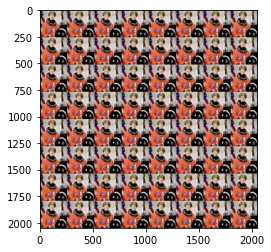

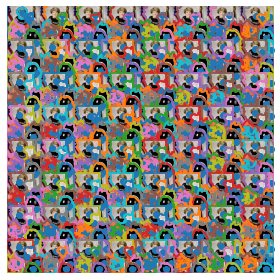

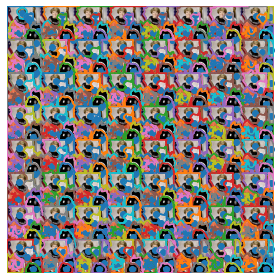

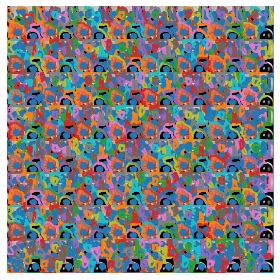

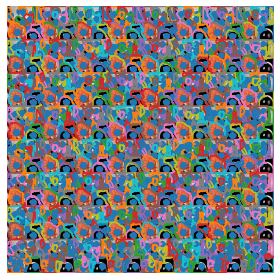

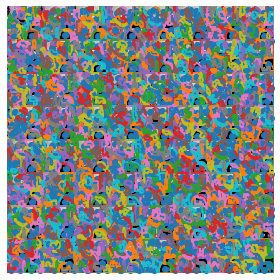

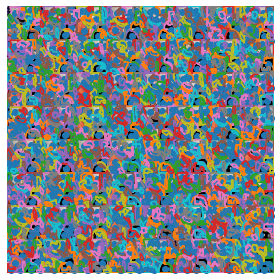

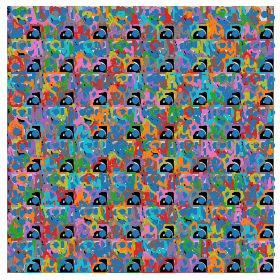

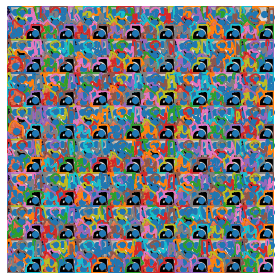

In [4]:
# Show the tiled input image we have been operating on
countFigure = 0
fig, ax = plt.subplots(num=countFigure)
countFigure = countFigure + 1
ax.imshow(img)

# We will show the tracings that we get using trace_object_boundaries2, defined above, for each of the SLIC algorithms.
# Should we also show the tracings that we get using histomicstk.segmentation.label.trace_object_boundaries?
show_slow = True

if show_slow:
    plotit(countFigure, img, label1, trace_object_boundaries)
    countFigure = countFigure + 1
plotit(countFigure, img, label1, trace_object_boundaries2)
countFigure = countFigure + 1
if show_slow:
    plotit(countFigure, img, label2, trace_object_boundaries)
    countFigure = countFigure + 1
plotit(countFigure, img, label2, trace_object_boundaries2)
countFigure = countFigure + 1
if show_slow:
    plotit(countFigure, img, label3, trace_object_boundaries)
    countFigure = countFigure + 1
plotit(countFigure, img, label3, trace_object_boundaries2)
countFigure = countFigure + 1
if show_slow:
    plotit(countFigure, img, label4, trace_object_boundaries)
    countFigure = countFigure + 1
plotit(countFigure, img, label4, trace_object_boundaries2)
countFigure = countFigure + 1